In [1]:
import keras_hub
import keras
import tensorflow as tf  # For tf.data only.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

2025-11-06 15:06:36.489647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762437996.501288   18315 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762437996.504961   18315 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762437996.515277   18315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762437996.515287   18315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762437996.515289   18315 computation_placer.cc:177] computation placer alr

In [2]:
!wget "https://github.com/rowanz/swagaf/archive/refs/heads/master.zip" -O swag.zip
!unzip -q swag.zip

--2025-11-06 15:02:06--  https://github.com/rowanz/swagaf/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/rowanz/swagaf/zip/refs/heads/master [following]
--2025-11-06 15:02:07--  https://codeload.github.com/rowanz/swagaf/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘swag.zip’

swag.zip                [               <=>  ]  19,94M  4,97MB/s    in 4,0s    

2025-11-06 15:02:11 (4,97 MB/s) - ‘swag.zip’ saved [20905751]



In [3]:
!ls swagaf-master/data

README.md  test.csv  train.csv	train_full.csv	val.csv  val_full.csv


In [2]:
class CFG:
    preset = "deberta_v3_extra_small_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    seed = 42  # Random seed
    epochs = 5  # Training epochs
    batch_size = 8  # Batch size
    augment = True  # Augmentation (Shuffle Options)

In [3]:
keras.utils.set_random_seed(CFG.seed)

In [4]:
# Train data
train_df = pd.read_csv(
    "swagaf-master/data/train.csv", index_col=0
)  # Read CSV file into a DataFrame
train_df = train_df.sample(frac=0.02)
print("# Train Data: {:,}".format(len(train_df)))

# Valid data
valid_df = pd.read_csv(
    "swagaf-master/data/val.csv", index_col=0
)  # Read CSV file into a DataFrame
valid_df = valid_df.sample(frac=0.02)
print("# Valid Data: {:,}".format(len(valid_df)))

# Train Data: 1,471
# Valid Data: 400


In [5]:
# Define a function to create options based on the prompt and choices
def make_options(row):
    row["options"] = [
        f"{row.startphrase}\n{row.ending0}",  # Option 0
        f"{row.startphrase}\n{row.ending1}",  # Option 1
        f"{row.startphrase}\n{row.ending2}",  # Option 2
        f"{row.startphrase}\n{row.ending3}",
    ]  # Option 3
    return row

In [6]:
train_df = train_df.apply(make_options, axis=1)
valid_df = valid_df.apply(make_options, axis=1)

In [7]:
preprocessor = keras_hub.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,  # Name of the model
    sequence_length=CFG.sequence_length,  # Max sequence length, will be padded if shorter
)

I0000 00:00:1762438010.217271   18315 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8864 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [8]:
outs = preprocessor(train_df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (4, 200)
padding_mask : (4, 200)


In [9]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (
        (text, label) if label is not None else text
    )  # Return processed text and label if available

In [10]:
def option_shuffle(options, labels, prob=0.50, seed=None):
    if tf.random.uniform([]) > prob:  # Shuffle probability check
        return options, labels
    # Shuffle indices of options and labels in the same order
    indices = tf.random.shuffle(tf.range(tf.shape(options)[0]), seed=seed)
    # Shuffle options and labels
    options = tf.gather(options, indices)
    labels = tf.gather(labels, indices)
    return options, labels

In [11]:
def augment_fn(text, label=None):
    text, label = option_shuffle(text, label, prob=0.5)  # Shuffle the options
    return (text, label) if label is not None else text

In [12]:
def build_dataset(
    texts,
    labels=None,
    batch_size=32,
    cache=False,
    augment=False,
    repeat=False,
    shuffle=1024,
):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (
        (texts,)
        if labels is None
        else (texts, keras.utils.to_categorical(labels, num_classes=4))
    )  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    if augment:  # Apply augmentation if enabled
        ds = ds.map(augment_fn, num_parallel_calls=AUTO)
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=True)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [13]:
# Build train dataloader
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.label.tolist()  # Extract training labels
train_ds = build_dataset(
    train_texts,
    train_labels,
    batch_size=CFG.batch_size,
    cache=True,
    shuffle=True,
    repeat=True,
    augment=CFG.augment,
)

# Build valid dataloader
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.label.tolist()  # Extract validation labels
valid_ds = build_dataset(
    valid_texts,
    valid_labels,
    batch_size=CFG.batch_size,
    cache=True,
    shuffle=False,
    repeat=False,
    augment=False,
)

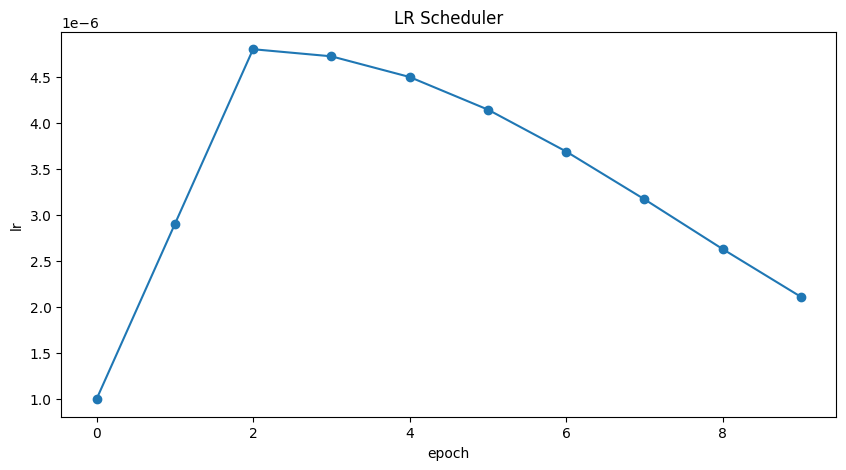

In [14]:
import math


def get_lr_callback(batch_size=8, mode="cos", epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep = 2, 0

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            decay_total_epochs, decay_epoch_index = (
                epochs - lr_ramp_ep - lr_sus_ep + 3,
                epoch - lr_ramp_ep - lr_sus_ep,
            )
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs),
            [lrfn(epoch) for epoch in np.arange(epochs)],
            marker="o",
        )
        plt.xlabel("epoch")
        plt.ylabel("lr")
        plt.title("LR Scheduler")
        plt.show()

    return keras.callbacks.LearningRateScheduler(
        lrfn, verbose=False
    )  # Create lr callback


_ = get_lr_callback(CFG.batch_size, plot=True)

In [15]:
def get_callbacks():
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        f"best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks
    return callbacks  # Return the list of callbacks


callbacks = get_callbacks()

In [16]:
# Selects one option from five
class SelectOption(keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super().__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        # Selects a specific slice from the inputs tensor
        return inputs[:, self.index, :]

    def get_config(self):
        # For serialize the model
        base_config = super().get_config()
        config = {
            "index": self.index,
        }
        return {**base_config, **config}


def build_model():
    # Define input layers
    inputs = {
        "token_ids": keras.Input(shape=(4, None), dtype="int32", name="token_ids"),
        "padding_mask": keras.Input(
            shape=(4, None), dtype="int32", name="padding_mask"
        ),
    }
    # Create a DebertaV3Classifier model
    classifier = keras_hub.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1,  # one output per one option, for five options total 5 outputs
    )
    logits = []
    # Loop through each option (Q+A), (Q+B) etc and compute associated logits
    for option_idx in range(4):
        option = {
            k: SelectOption(option_idx, name=f"{k}_{option_idx}")(v)
            for k, v in inputs.items()
        }
        logit = classifier(option)
        logits.append(logit)

    # Compute final output
    logits = keras.layers.Concatenate(axis=-1)(logits)
    outputs = keras.layers.Softmax(axis=-1)(logits)
    model = keras.Model(inputs, outputs)

    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
        jit_compile=True,
    )
    return model


# Build the Build
model = build_model()

100%|████████████████████████████████████████| 270M/270M [00:08<00:00, 32.8MB/s]


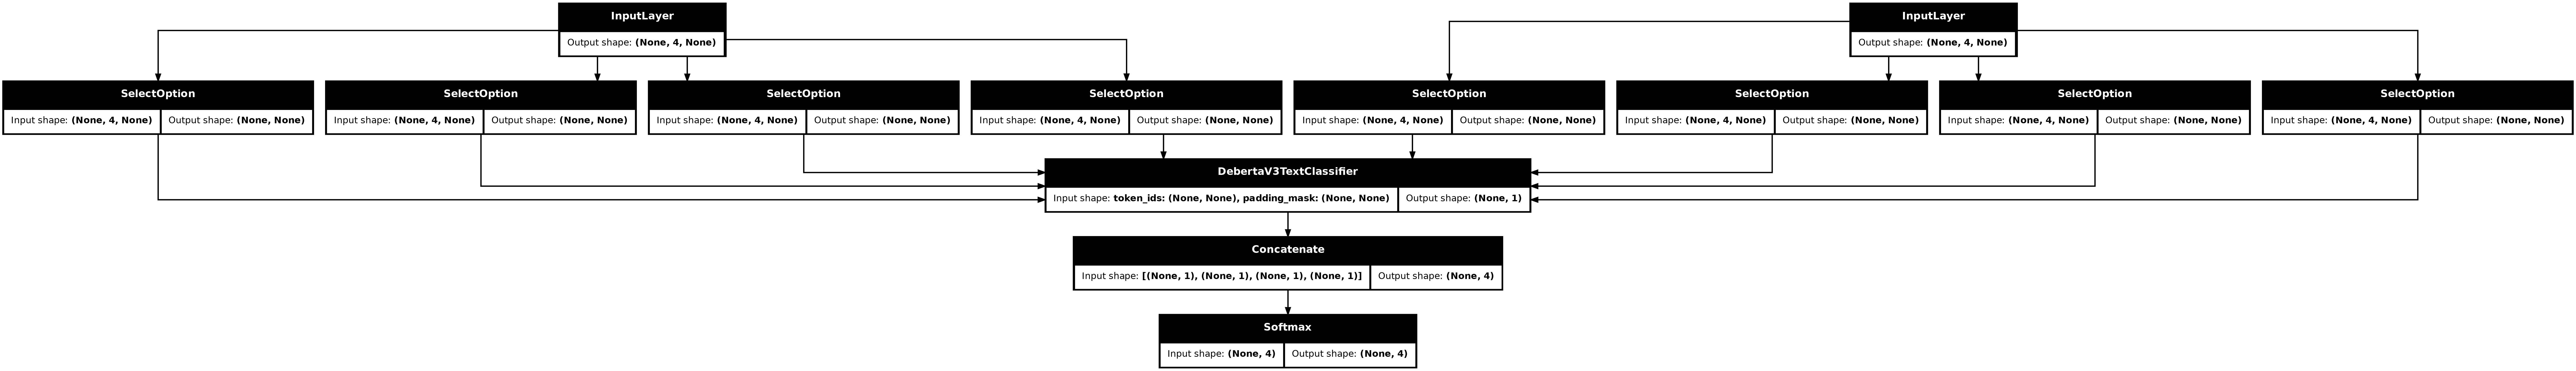

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=callbacks,
    steps_per_epoch=int(len(train_df) / CFG.batch_size),
    verbose=1,
)

Epoch 1/5


I0000 00:00:1762438073.806613   18425 service.cc:152] XLA service 0x7e97fc003a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762438073.806627   18425 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-06 15:07:56.515854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762438081.668284   18425 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-11-06 15:09:16.386848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_21', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_21', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are s

183/183 ━━━━━━━━━━━━━━━━━━━━ 207s 421ms/step - accuracy: 0.2739 - loss: 1.3866 - val_accuracy: 0.6600 - val_loss: 1.3762 - learning_rate: 1.0000e-06
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 80s 439ms/step - accuracy: 0.4665 - loss: 1.2569 - val_accuracy: 0.7450 - val_loss: 0.9998 - learning_rate: 2.9000e-06
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 74s 406ms/step - accuracy: 0.6113 - loss: 0.9980 - val_accuracy: 0.7275 - val_loss: 0.7695 - learning_rate: 4.8000e-06
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 77s 422ms/step - accuracy: 0.6742 - loss: 0.8549 - val_accuracy: 0.7250 - val_loss: 0.7700 - learning_rate: 4.7230e-06
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 84s 460ms/step - accuracy: 0.7158 - loss: 0.7641 - val_accuracy: 0.7525 - val_loss: 0.7200 - learning_rate: 4.4984e-06


In [19]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=CFG.batch_size,  # max batch size = valid size
    verbose=1,
)

# Format predictions and true answers
pred_answers = np.arange(4)[np.argsort(-predictions)][:, 0]
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(0, 50, 10):
    row = valid_df.iloc[i]
    question = row.startphrase
    pred_answer = f"ending{pred_answers[i]}"
    true_answer = f"ending{true_answers[i]}"
    print(f"❓ Sentence {i+1}:\n{question}\n")
    print(f"✅ True Ending: {true_answer}\n   >> {row[true_answer]}\n")
    print(f"🤖 Predicted Ending: {pred_answer}\n   >> {row[pred_answer]}\n")
    print("-" * 90, "\n")

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step
# Predictions

❓ Sentence 1:
The man shows the teens how to move the oars. The teens

✅ True Ending: ending3
   >> follow the instructions of the man and row the oars.

🤖 Predicted Ending: ending3
   >> follow the instructions of the man and row the oars.

------------------------------------------------------------------------------------------ 

❓ Sentence 11:
A lake reflects the mountains and the sky. Someone

✅ True Ending: ending2
   >> runs along a desert highway.

🤖 Predicted Ending: ending1
   >> remains by the door.

------------------------------------------------------------------------------------------ 

❓ Sentence 21:
On screen, she smiles as someone holds up a present. He watches somberly as on screen, his mother

✅ True Ending: ending1
   >> picks him up and plays with him in the garden.

🤖 Predicted Ending: ending0
   >> comes out of her apartment, glowers at her laptop.

---------------------------------------------------------